# Exploratory Data Analysis and Building ML Model for Diabetes Prediction

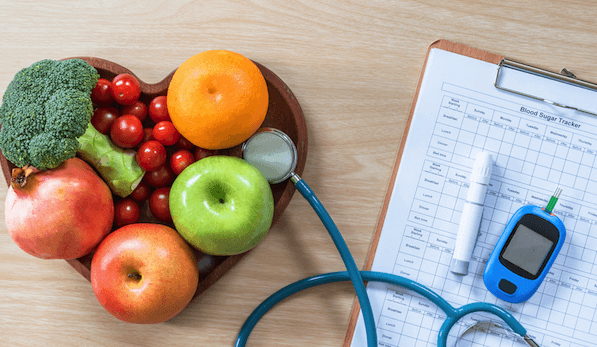

**Diabetes is a disease that occurs when your blood glucose, also called blood sugar, is too high. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.**

**We will explore this dataset and find out factors that contribute the most for diabetes causation. We will also build Machine Learning Models that can help to predict whether a person is diabetic or not and try to improve the model by performing Cross Validation and hyperparameter tuning.**

**Do Upvote the notebook if you liked it!**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

In [ ]:
df.head()

The different columns present in the dataset are:

* Pregnancies -> Number of times Pregnant

* Glucose -> Plasma glucose concentration

* BloodPressure -> Diastolic blood pressure (mm Hg)

* SkinThickness -> Triceps skin fold thickness (mm)

* Insulin -> 2-Hour serum insulin (mu U/ml)

* BMI -> Body Mass Index

* DiabetesPedigreeFunction -> Diabetes pedigree function

* Age -> Age in years

* Outcome -> Whether the lady is diabetic or not, 0 represents the person is not diabetic and 1 represents that the person is diabetic.



In [ ]:
print("Number of rows present in the dataset are: ", df.shape)

In [ ]:
df.info()

In [ ]:
df.describe().T

In [ ]:
import seaborn as sns
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

sns.countplot(df['Outcome'])
plt.show()

In [ ]:
df['Outcome'].value_counts()

In [ ]:
fig, ax = plt.subplots()

labels = ['Diabetic', 
         'Non-Diabetic']
percentages = [34.89, 65.10]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels, autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

**The distribution of the dependent variable is not skewed or imbalanced. We can move ahead with the same data without having to apply SMOTE or undersampling or oversampling techniques. But we do need to make that we distribution of the classes remain same when we split our data to train and test set.**

**Before we move ahead, we need to check what are the minimum values for each column, certain columns like Glucose or Insulin can not have values as 0. Therefore, we need to take care of such values.**

In [ ]:
for col in df.columns:
    print("The minimum value fore the columns {} is {}".format(col, df[col].min()))

**Now out of the above columns having zero as their minima, only Pregnancie Column can take the values as zero, so what should do we do with those columns that have zero as their minimum even if they aren't supposed to?**

# Null Values

In [ ]:
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+2.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 0.5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()
msv_1(df, 20, color=sns.color_palette('Reds',15))

**You might be wondering that there are no null values in the dataset, but are you sure? Remember what we had discussed in the previous section where certain columns were having zero as their minima eventhough they aren't supposed to. Those values will be considered as null values. Let's replace the zeros present in the Glucose, BloodPressure, SkinThickness, Insulin, and BMI columns with null.**

In [ ]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

In [ ]:
msv_1(df, 20, color=sns.color_palette('Reds',15))

**We can observe that Insulin column has close to 50% zero or null values, followed by SkinThickness that has close to 30% missing values. We will be filling these values later.**

# Exploratory Data Analysis

**In this section, we will be doing some basic Exploratory Data Analysis to get the "feel" of the data, we will be checking the distributions, the correlations etc of the different columns and try to remove the null values present.**

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()
ax_idx = 0
columns = df.drop('Outcome', axis = 1).columns
for col in columns:
    df[col].plot(kind = 'hist', ax = axes[ax_idx], title = col, color = next(color_cycle))
    ax_idx += 1

plt.suptitle('Sales Trend according to Departments')
plt.tight_layout()
plt.show()

**Let's check the skewness of each of the columns.**

**Skewness refers to the amount of asymmetry in the given feature or in other words amount of distortions from the normal distribution. The peak of the histogram represents the mode.**

In [ ]:
from scipy.stats import skew
for col in df.drop('Outcome', axis = 1).columns:
    print("Skewness for the column {} is {}".format(col, df[col].skew()))

**Columns like Pregnancies, Glucose, BloodPressure, SkinThickness and BMI are not that much skewed. We can fill null values with the mean for these columns, but for columns like Insulin and DiabetesPedigreeFunction, we will have to replace them will median due to the effect of skewness.**

In [ ]:
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].median()) # Filling null values with the median.

for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
msv_1(df, 10, color=sns.color_palette('Greens',15))

In [ ]:
df.isnull().sum()

**All null values are taken care of now**

In [ ]:
def mean_target(var):
    """
    A function that will return the mean values for 'var' column depending on whether the person
    is diabetic or not
    """
    return pd.DataFrame(df.groupby('Outcome').mean()[var])

In [ ]:
def distplot(col_name):
    """
    A function that will plot the distribution of column 'col_name' for diabetic and non-diabetic people separately
    """
    plt.figure()
    ax = sns.distplot(df[col_name][df.Outcome == 1], color ="red", rug = True)
    sns.distplot(df[col_name][df.Outcome == 0], color ="lightblue",rug = True)
    plt.legend(['Diabetes', 'No Diabetes'])

## Pregnancies

In [ ]:
distplot('Pregnancies')

In [ ]:
mean_target('Pregnancies')

**We can see that the number of pregnancies is high for the diabetic people**

## Insulin

In [ ]:
distplot('Insulin')

In [ ]:
mean_target('Insulin')

**Diabetic People tend to have more Insulin level.**

## BloodPressure

In [ ]:
distplot('BloodPressure')

In [ ]:
mean_target('BloodPressure')

**The mean of the blood pressure is greater for diabetic people as compared to the non-diabetic people**

## Glucose

In [ ]:
distplot('Glucose')

In [ ]:
mean_target('Glucose')

**Diabetic People tend to have much higher Glucose level**

# Comman Man Analysis

**Let's think like a common man, and analyze the data.**

**First, we would know what is the effect of Age on the Outcome because we have heard that as the age increases, the chances of diabetes also commonly increases.**

In [ ]:
sns.boxplot(x = 'Outcome', y = 'Age', data = df)
plt.title('Age vs Outcome')
plt.show()

**Yes, we were right, the median of the age of diabetic people is greater than that of non-diabetic people.**

**Let's also check the effect of Blood Pressure on the Outcome.**

In [ ]:
sns.boxplot(x = 'Outcome', y = 'BloodPressure', data = df, palette = 'Blues')
plt.title('BP vs Outcome')
plt.show()

**The median of the BloodPressure of diabetic people lies close to the 75th Percentile of non-diabetic people.**

**The next thing a common man would check is the relationship between age and BP**

In [ ]:
sns.jointplot(x='Age',y='BloodPressure', data=df, kind = 'reg', color = 'green')

**Hmm, as the age increases, generally the Blood Pressure also increases**

**One would also want to know the chances of getting diabetes, if it is common in the family. We can check that with the Diabetes Pedigree Function.**

In [ ]:
my_pal = {0: "lightgreen", 1: "lightblue"}
sns.boxplot(x = 'Outcome', y = 'DiabetesPedigreeFunction', data = df, palette = my_pal)
plt.title('DPF vs Outcome')
plt.show()

**Quite a proportion of people having high DPF does not end up having Diabetes.  But usually the diabetic people have DPF value close to 0.5 (50th Percentile)**

## Gluscose Level

In [ ]:
my_pal = {0: "lightgrey", 1: "lightyellow"}
sns.boxplot(x = 'Outcome', y = 'Glucose', data = df, palette = my_pal)
plt.title('Glucose vs Outcome')
plt.show()

**Wow! the median of the Glucose level of Diabetic People is greater than the 75th Percentile of the glucose level of non-diabetic people. Therefore having a high glucose level does increase the chances of having diabetes.**

## Insulin

**Let's first check whether there is any relation between glucose and insulin level.**

In [ ]:
sns.jointplot(x='Insulin',y='Glucose', data=df, kind = 'reg', color = 'red')
plt.show()

**We can see that as the insulin level increases, the Glucose level also increases.**

In [ ]:
sns.boxplot(x = 'Outcome', y = 'Insulin', data = df)
plt.title('Insulin vs Outcome')
plt.show()

## Body Mass Index

**Body mass index (BMI) is a measure of body fat based on height and weight that applies to adult men and women. Does having a higher BMI leads to more chances of being diabetic? Let's check that out!**

In [ ]:
my_pal = {0: "lightyellow", 1: "lightpink"}
sns.boxplot(x = 'Outcome', y = 'BMI', data = df, palette = my_pal)
plt.title('BMI vs Outcome')
plt.show()

**Indeed, the Median BMI of the Diabetic People is greater than the Median BMI of the Non-Diabetic people.**

# Correlation Matrix

In [ ]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

**From the above heatmap, we can observe that all the features are weakly correlated, so that removes multicollinearity out of equation. Multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. Models like Logistic Regression assumes the presence of non-collinearity among the features, if multicollinearity is present it can lead to the bad performance of such models.**

# Dataset Splitting and Features Scaling

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Outcome', axis = 1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

**Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.**

**This can be thought of as subtracting the mean value or centering the data. Scaling the features is of utmost importance because different features are in different scales. Let's say the Age has values in double digits, whereas the DPF is of the kind float, the effect of the Age feature will be more as compared to the DPF**

**Best practice is to use only the training set to figure out how to scale / normalize, then blindly apply the same transform to the test set.**

**For example, say you're going to normalize the data by removing the mean and dividing out the variance. If you use the whole dataset to figure out the feature mean and variance, you're using knowledge about the distribution of the test set to set the scale of the training set - 'leaking' information.**

**The right way to do this is to use only the training set to calculate the mean and variance, normalize the training set, and then at test time, use that same (training) mean and variance to normalize the test set.**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train =  pd.DataFrame(sc.fit_transform(X_train),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
X_test = pd.DataFrame(sc.fit_transform(X_test),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])

# Baseline Models

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def evaluation(model, x_train_std, y_train, x_test, y_test, train = True):
    """
    A function that returns the score of every evaluation metrics
    """
    if train == True:
        pred = model.predict(x_train_std)
        classifier_report = pd.DataFrame(classification_report(y_train, pred, output_dict = True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"F1 Score: {round(f1_score(y_train, pred), 2)}")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{classifier_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    if train == False:
        pred = model.predict(x_test)
        classifier_report = pd.DataFrame(classification_report(y_test, pred, output_dict = True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"F1 Score: {round(f1_score(y_test, pred), 2)}")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{classifier_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train, y_train)

evaluation(lr, X_train, y_train, X_test, y_test, True)
print()
evaluation(lr, X_train, y_train, X_test, y_test, False)

**The F1 score we got using Logistic Regression is very less, and in the Confusion Matrix it is visible that 53 wrong predictions has been made. We need to improve it.**

In [ ]:
train_score_lr = round(accuracy_score(y_train, lr.predict(X_train)) * 100, 2)
test_score_lr = round(accuracy_score(y_test, lr.predict(X_test)) * 100, 2)

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

evaluation(dtc, X_train, y_train, X_test, y_test, True)
print()
evaluation(dtc, X_train, y_train, X_test, y_test, False)

**We know that Decision Tree Classifier is prone to Overfitting, and that's what we have got here. We can see that the train accuracy is 100% but the test accuracy is only 67.71%. We also know that Random Forest Classifier helps to overcome this drawback of Decision Tree Classifer. Let's check that model out.**

In [ ]:
train_score_dtc = round(accuracy_score(y_train, dtc.predict(X_train)) * 100, 2)
test_score_dtc = round(accuracy_score(y_test, dtc.predict(X_test)) * 100, 2)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
## Finding out the right number of estimators
accuracy_scores = []
for i in range(1, 1000, 100):
    rfc = RandomForestClassifier(n_estimators = i, random_state = 0)
    rfc.fit(X_train, y_train)
    accuracy_scores.append(accuracy_score(y_test, rfc.predict(X_test)))
plt.plot(accuracy_scores)

**Maximum test accuracy is achieved using 500 trees**

In [ ]:
rfc = RandomForestClassifier(n_estimators = 500)
rfc.fit(X_train, y_train)

evaluation(rfc, X_train, y_train, X_test, y_test, True)
print()
evaluation(rfc, X_train, y_train, X_test, y_test, False)

**Here also the model has overfitted, but the test accuracy has increased to 74%. And 50 wrong predictions are being made. We can also observe that the precision, recall and F1 score is less for the diabetic people. This means that there is a lack of training instances for the outcome '1'. We will be using Cross Validation later in the notebook**

In [ ]:
train_score_rfc = round(accuracy_score(y_train, rfc.predict(X_train)) * 100, 2)
test_score_rfc = round(accuracy_score(y_test, rfc.predict(X_test)) * 100, 2)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

accuracy_scores = []

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    accuracy_scores.append(accuracy_score(y_test, knn.predict(X_test)))
    
plt.plot(accuracy_scores)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train)

evaluation(knn, X_train, y_train, X_test, y_test, True)
evaluation(knn, X_train, y_train, X_test, y_test, False)

In [ ]:
train_score_knn = round(accuracy_score(y_train, knn.predict(X_train)) * 100, 2)
test_score_knn = round(accuracy_score(y_test, knn.predict(X_test)) * 100, 2)

## XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators = 500, learning_rate = 0.15)
xgb.fit(X_train, y_train)

evaluation(xgb, X_train, y_train, X_test, y_test, True)
evaluation(xgb, X_train, y_train, X_test, y_test, False)

In [ ]:
train_score_xgb = round(accuracy_score(y_train, xgb.predict(X_train)) * 100, 2)
test_score_xgb = round(accuracy_score(y_test, xgb.predict(X_test)) * 100, 2)

In [ ]:
models = {
           'Train Accuracy': [train_score_lr, train_score_dtc, train_score_rfc, train_score_knn, train_score_xgb],
          'Test Accuracy' : [test_score_lr, test_score_dtc, test_score_rfc, test_score_knn, test_score_xgb]
         }

models = pd.DataFrame(models, index = ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'K-Nearest Neighbor', 'XGBoost'])
models.head()

**We can observe from the above dataframe that Decision Tree Classifier, Random Forest Classifier, and XGBoost have all overfitted the given dataset. Let's explore the results when we use Cross Validation.**

# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

kfold = StratifiedKFold(n_splits=10)

random_state = 0
classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state, n_estimators = 500))
classifiers.append(KNeighborsClassifier())
classifiers.append(XGBClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["Logistic Regression","Decision Tree",
"Random Forest", "KNeighboors", "XGBoosting"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
cv_res.head()

**From the above table, we can observe that we get the best results for Logistic Regression Algorithm, the accuracy in the case is 78.3%. The Results for Random Forest and KNeighbors Classifer is also not bad. Let's try out Hyperparameter Tuning using GridSearchCv for Random Forest Classifier and XGBoost Classifier**

# Hyperparameter Tuning

### Random Forest Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

**By Hyperparameters tuning, we get the best accuracy as 77% and the hyperparameters that give the best result are shown below.**

In [ ]:
print(RFC_best)

### XGBoost Classifier

In [ ]:
# XGBoosting Classifier tunning

XGB = XGBClassifier(verbosity = 0)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsXGB = GridSearchCV(XGB, param_grid = gb_param_grid, cv=kfold, scoring="accuracy")

gsXGB.fit(X_train,y_train)

XGB_best = gsXGB.best_estimator_
# Best score
gsXGB.best_score_

In [ ]:
XGB_best

**Hope you liked the notebook, any suggestions would be highly appreciated.**

**I will continue experimenting in future versions of the notebook.**

**Please upvote if you liked it.**